# Construct a circuit
<br>
Fist, construct a simple circuit and compare result from different number of measurement.

In [1]:
import pennylane as qml  ### pennylane for optimizing the circuit.
from pennylane import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
sns.set_style("darkgrid")

c:\users\asus\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\asus\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\asus\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\asus\appdata\

In [2]:
dev = qml.device("default.qubit", wires=2, analytic=True)
def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RX(params[1], wires=1)
    qml.RY(params[2], wires=0)
    qml.RY(params[3], wires=1)
    qml.CNOT(wires=[0, 1])

    
### measurement
@qml.qnode(dev)
def get_prob(params):
    circuit(params)
    return qml.probs(wires=[0, 1])

In [3]:
print(get_prob([0,0,0,0]))
print(get_prob.draw())

[1. 0. 0. 0.]
 0: ──RX(0)──RY(0)──╭C──╭┤ Probs 
 1: ──RX(0)──RY(0)──╰X──╰┤ Probs 



# Optimize the circuit

<h3>Loss function </h3> <br>
Given $\alpha_i$ as a probability of getting result in state $i$.<br>
<br>
$|\varphi> = \alpha_0|00> + \alpha_1|01> + \alpha_2|10> + \alpha_3|11>$
<br>
<br>
The result should be |10> and |11> with equal probability, the loss function is<br>
<br>
$loss = (0.5-\alpha_1)^2 + (0.5 - \alpha_2)^2 $

In [4]:
def cost(param):
    alpha = get_prob(param)
    loss = (0.5-alpha[1])**2 + (0.5-alpha[2]) **2
    return loss

<h3>Randomly initializ parameters with small numbers</h3>

In [5]:
init_params = np.random.rand(4)/10
print(init_params)

[0.03706311 0.08369539 0.05524304 0.01081938]


<h3>Circuit optimize function</h3>
Pennylane provides optimizers that can do autograd of quantum circuit.<br>
The circuit will be optimize using gradient desent with AdamOptimizer. AdamOptimizer will helps learning parameters faster and move closer to the global minima with adaptive learning rate.

In [6]:
def optimize_circuit(init_params, cost, optimizer = qml.AdamOptimizer, stepsize = 0.1, steps = 200):
    opt = optimizer(stepsize = stepsize)
    params = init_params

    lower_bound = 0
    upper_bound = np.pi
    loss = []
    for i in range(steps):
        # update the circuit parameters
        params = opt.step(cost, params)
        loss.append(cost(params))
    
    return loss,params

In [7]:
loss_no_noise, params = optimize_circuit(init_params,cost = cost)

In [8]:
print('optimized loss: ',loss_no_noise[-1])
print('optimized params: ',params)

optimized loss:  3.3381711579527066e-06
optimized params:  [ 1.29710696 -0.0921862   1.57080313  3.18461953]


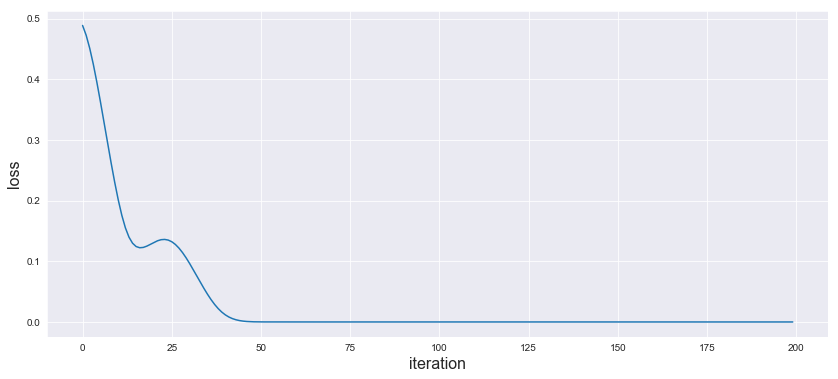

In [9]:
figure(num=None, figsize=(14, 6))
plt.ylabel('loss', fontsize=16)
plt.xlabel('iteration', fontsize=16)
plt.plot(loss_no_noise)

In [10]:
get_prob(params)

array([0.00129193, 0.49870715, 0.49870899, 0.00129193])

In [11]:
print('final statevector: ',dev.state)

final statevector:  [ 0.00756596-0.03513808j  0.56322732+0.4260072j   0.56238444-0.42712144j
 -0.03178534-0.01678169j]


# Optimize noisy device

In [12]:
noisy_dev = qml.device("cirq.mixedsimulator", wires=2, shots =1000 ,analytic=False)
#noisy backend

@qml.qnode(noisy_dev)
def get_probs_noisy_circuit(params):
    circuit(params)
    return qml.probs(wires=[0, 1])

New cost function has is the same as previous cost but measures with different number of shots.

In [13]:
# new cost function
def cost_noisy_circuit(param):
    alpha = get_probs_noisy_circuit(param)
    loss = (0.5-alpha[1])**2 + (0.5-alpha[2])**2
    return loss

# Experiment

In [14]:
def show_result(loss, params):
    print('optimized loss: ',loss[-1])
    print('optimized params: ',params)

    figure(num=None, figsize=(14, 6))
    plt.ylabel('loss', fontsize=16)
    plt.xlabel('iteration', fontsize=16)
    plt.plot(loss)

    print('probability: ',get_probs_noisy_circuit(params))

### 1 shot per iteration

In [15]:
init_params

tensor([0.03706311, 0.08369539, 0.05524304, 0.01081938], requires_grad=True)

In [16]:
noisy_dev.shots = 1
loss_1shot, params = optimize_circuit(init_params, cost = cost_noisy_circuit)

optimized loss:  0.5
optimized params:  [-2.06240704 -0.92071997 -1.99550483 -2.57140608]
probability:  [0. 0. 0. 1.]


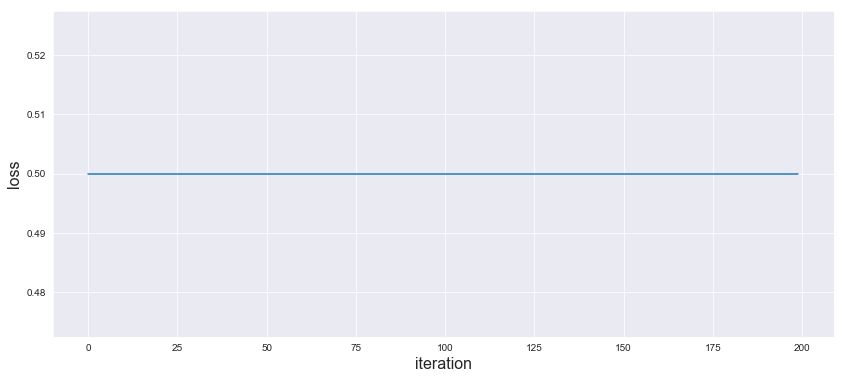

In [17]:
show_result(loss_1shot, params)

### 10 shot per iteration

In [18]:
noisy_dev.shots = 10
loss_10shot, params = optimize_circuit(init_params, cost = cost_noisy_circuit)

optimized loss:  0.01999999999999999
optimized params:  [ 1.57660164  0.46630841 -1.5667438  -3.44210649]
probability:  [0.  0.6 0.4 0. ]


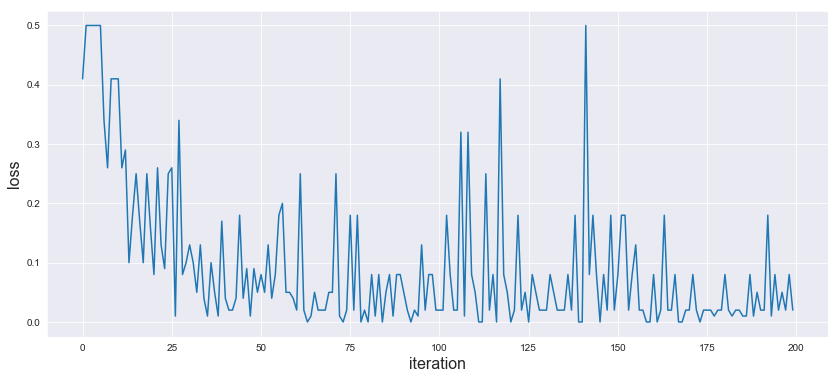

In [19]:
show_result(loss_10shot, params)

### 100 shot per iteration

In [20]:
noisy_dev.shots = 100
loss_100shot, params = optimize_circuit(init_params, cost = cost_noisy_circuit)

optimized loss:  0.0008000000000000014
optimized params:  [-1.50355989 -0.04929528 -1.83118169  3.13966841]
probability:  [0.01 0.41 0.57 0.01]


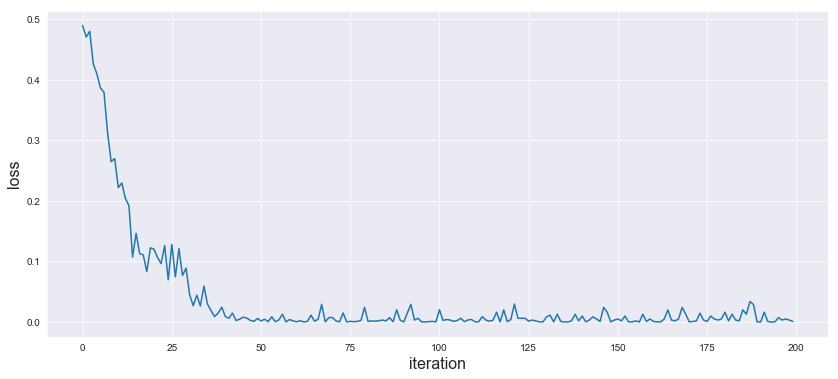

In [21]:
show_result(loss_100shot, params)

### 1000 shot per iteration

In [22]:
noisy_dev.shots = 1000
loss_1000shot, params = optimize_circuit(init_params, cost = cost_noisy_circuit)

optimized loss:  0.0006970000000000012
optimized params:  [ 1.65126877 -0.07380053 -1.54422377  3.20608312]
probability:  [0.002 0.515 0.48  0.003]


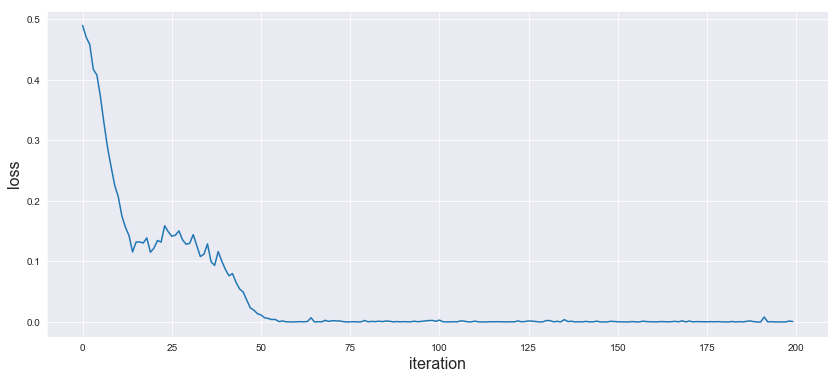

In [23]:
show_result(loss_1000shot, params)

# compare result

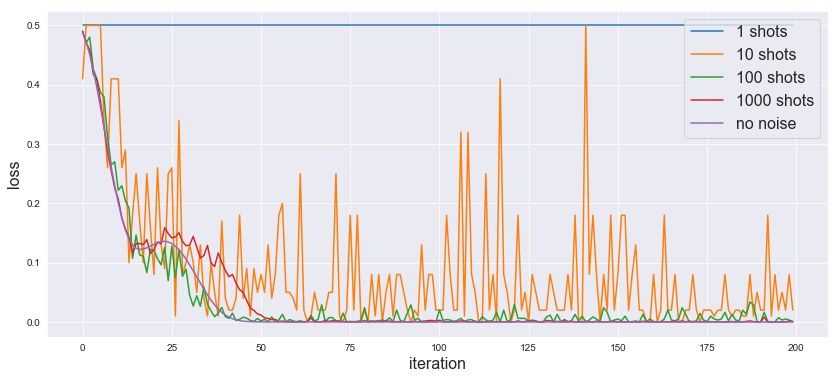

In [24]:
figure(num=None, figsize=(14, 6))
plt.ylabel('loss', fontsize=16)
plt.xlabel('iteration', fontsize=16)

plt.plot(loss_1shot, label = '1 shots')
plt.plot(loss_10shot, label = '10 shots')
plt.plot(loss_100shot, label = '100 shots')
plt.plot(loss_1000shot, label = '1000 shots')
plt.plot(loss_no_noise, label = 'no noise')

plt.legend(loc="upper right", fontsize=16)


From the experiment, number of measurement per iteration effect direction of gradient. With same parameters, the probability from measurements changes all the times and precision of the probability depends on number of shots. The more shot is the more precise probability.

# Try to make sure that the circuit produces state |01>+|10>

From the previous model, our optimized parameters make the circuit gives probability of 0.5|01> and 0.5|10> but the state vector is not $(\sqrt0.5)|01> + (\sqrt0.5)|10>$.

In [25]:
## prvious optimized parameters
loss_no_noise, params = optimize_circuit(init_params,cost = cost)
print('final statevector: ',dev.state)

final statevector:  [ 0.00756596-0.03513808j  0.56322732+0.4260072j   0.56238444-0.42712144j
 -0.03178534-0.01678169j]


To make sure that circuit produces state |01>+|10> not other state, My idea is to apply 2 Measurement on different basis in the same iteration. 

### new measurement basis

From another part, I already explored the correct parameters and try to reverse engineering the result to the circuit.<br>

In [26]:
correct_params = np.array([0,0,np.pi/2,np.pi])
optimize_circuit(correct_params,cost = cost)
print('final statevector: ',dev.state)

final statevector:  [4.32978028e-17+0.j 7.07106781e-01+0.j 7.07106781e-01+0.j
 4.32978028e-17+0.j]


I construct a circuit with extra gates at the end of the circuit.

In [27]:
@qml.qnode(dev)
def new_measurements(params):
    circuit(params)
    qml.CNOT(wires = [1,0])
    qml.RY(np.pi/2, wires = 1)
    return qml.probs(wires=[0, 1])

In [28]:
print(new_measurements(correct_params))

[0.00000000e+00 3.74939946e-33 0.00000000e+00 1.00000000e+00]


If the parameters correct, the new circuit should return state |11> with 100%<br>
Then I add new variables into the cost function. The new cost has to measure 2 circuits, each circuit has the same parameters.

In [29]:
def cost_2(params):
    alpha = get_prob(params)
    new_basis = new_measurements(params) # new circuit
    loss = (0.5-alpha[1])**2 + (0.5-alpha[2]) **2 + (1-new_basis[3])**2
    return loss

In [30]:
init_params

tensor([0.03706311, 0.08369539, 0.05524304, 0.01081938], requires_grad=True)

In [31]:
loss_2_measure , new_params = optimize_circuit(init_params, cost = cost_2)

optimized loss:  8.932120571645128e-06
optimized params:  [-5.27745240e-06 -8.42788966e-02  1.57077992e+00  3.19328613e+00]
probability:  [0.    0.506 0.493 0.001]


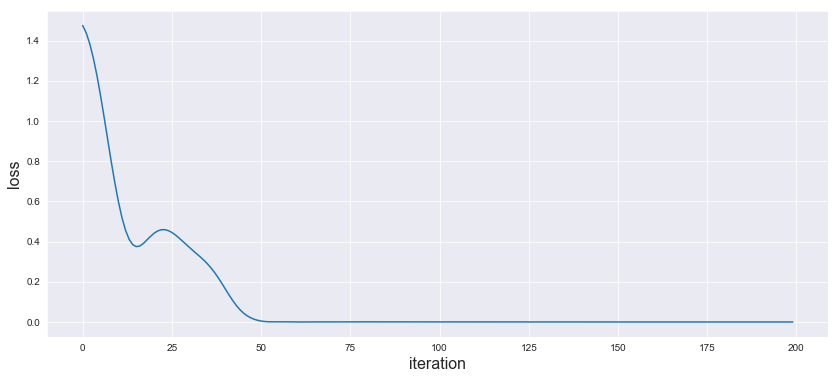

In [32]:
show_result(loss_2_measure, new_params)

In [33]:
get_prob(new_params)
print('final statevector: ',dev.state)

final statevector:  [-0.01825837-0.02977852j  0.70624888-0.00077171j  0.70623729-0.00076797j
 -0.01825792-0.02977813j]


The statevector from the new optimized parameters is $(\sqrt0.5)|01> + (\sqrt0.5)|10>$.
I found that sometime it results in $-(\sqrt0.5i)|01> -(\sqrt0.5i)|10>$ depends on initial parameters.

In [40]:
for i in range(0,5):
    random_params = np.random.rand(4)
    loss, new_rand_param = optimize_circuit(random_params, cost = cost_2)
    get_prob(new_rand_param)
    print('final statevector: ',dev.state)

final statevector:  [ 4.22829e-02+5.10428e-04j  7.98789e-05-7.05836e-01j
 -1.90786e-05-7.05847e-01j  4.22836e-02+5.04508e-04j]
final statevector:  [-0.0195 -0.02989j  0.7062 -0.00081j  0.70621-0.00084j -0.0195 -0.02989j]
final statevector:  [ 0.05552-0.01361j -0.00108-0.70479j -0.00107-0.70479j  0.05552-0.01361j]
final statevector:  [ 0.04979-0.01095j -0.00077-0.70528j -0.00078-0.70526j  0.04979-0.01095j]
final statevector:  [-0.0257 +0.01705j  0.70643+0.00062j  0.70644+0.00062j -0.0257 +0.01705j]


In the <a href="Task_2_Part_2.ipynb">Part 2</a> I will give my answers how I make sure that I produce state |01> + |10>